<a href="https://colab.research.google.com/github/Ness731/3-Min-Deeplearning/blob/main/Chapter_6_%EC%82%AC%EB%9E%8C%EC%9D%98_%EC%A7%80%EB%8F%84_%EC%97%86%EC%9D%B4_%ED%95%99%EC%8A%B5%ED%95%98%EB%8A%94_%EC%98%A4%ED%86%A0%EC%9D%B8%EC%BD%94%EB%8D%94.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 필수 라이브러리 import
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

In [2]:
import matplotlib.pyplot as plt # 데이터 시각화
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D # matpotlib에서 3차원의 plot을 그리는 용도
from matplotlib import cm # 데이터 포인트에 색상을 입히는 데 사용
import numpy as np # 행렬연산

In [3]:
# 하이퍼파라미터
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device:", DEVICE)

Using Device: cpu


In [4]:
# Fashion MNIST 데이터셋 로딩
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)
train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

torch.Size([64, 1, 28, 28])
torch.Size([64])


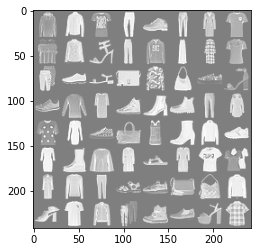

In [5]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))

## 오토인코더(Autoencoder)
- __오토인코더의 정의__<br>
  __오토인코더(Autoencoder)__는 비지도(unsupervised)방식으로 훈련된 인공신경망으로, 먼저 데이터에 인코딩 된 표현을 학습한 다음, 학습된 인코딩 표현에서 입력 데이터와 최대한 가깝게 복원해내는 것을 목표로 한다.<br>

  _| 오토인코더의 출력 == 입력에 대한 예측 |_
  <br>

- __오토인코더의 구조__<br>
  오토인코더는 크게 __(1) 인코더 부분__과 __(2) 디코더 부분__으로 나눌 수 있다. <br>
  __1) 인코더(Encoder)__<br>
  입력 데이터와 동일한 차원으로 시작해서 점차 차원이 줄어드는 구조이며, 최종 출력 차원은 추출된 특징의 개수를 나타낸다.<br>
  __2) 디코더(Decoder)__<br>
  인코더를 거친 최종 데이터의 차원으로 시작해서 원본 입력 데이터와 동일한 차원으로 출력되는 구조로, 모델이 추출한 특징으로부터 원본 이미지를 복원하는 개념이다.<br>
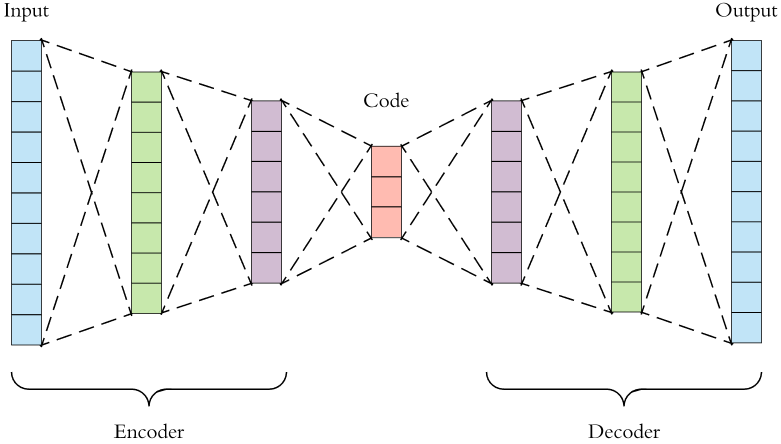

- __오토인코더 구현__<br>
  오토인코더 또한 이전에 구현했던 다른 신경망과 비슷한 구조를 가진다. 차이점은 encoder와 decoder의 두 신경망을 포함하고 있다는 것이다.<br>
  1) `__init__()`<br>
    초기화 함수에서는 신경망에서 사용할 모듈을 정의한다.
    - self.encoder
    - self.decoder
    - nn.Sequential() : 여러 개의 요소들로 이루어진 모듈을 순차적으로 실행하도록 담는 컨테이너 개념
    <br>

  2) `forward()`<br>
    초기화 함수에서 정의했던 `encoder`와 `decoder`를 이용하여 오토인코더의 연산 흐름을 정의한다.

In [6]:
# 오토인코더 구현부
class Autoencoder(nn.Module):
  # 초기화 함수
  def __init__(self):
    super(Autoencoder, self).__init__()
    # 초기화 함수에서는 인코더와 디코더를 정의한다.
    # Fasion Data: torch.Size([64, 1, 28, 28]) = 28*28 크기의 흑백 이미지가 64장 있음

    # 1. 인코더 - 점점 줄어드는 구조
    self.encoder = nn.Sequential(
        nn.Linear(28 * 28, 128), # 입력층은 데이터 크기와 동일해야 함
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 12),
        nn.ReLU(),
        nn.Linear(12, 3), # 최종적으로 추출하는 feature은 3개
    )

    # 2. 디코더 - 점점 늘어나는 구조
    self.decoder = nn.Sequential(
        nn.Linear(3, 12), # 입력층은 인코더가 최종적으로 추출한 사이즈와 동일해야 함
        nn.ReLU(),
        nn.Linear(12, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 28 * 28), # 최종 출력은 입력 데이터 크기와 동일해야 함
        nn.Sigmoid(),
    )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded

In [7]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr = 0.005)
criterion = nn.MSELoss()

In [8]:
view_data = trainset.data[:5].view(-1, 28*28)
view_data = view_data.type(torch.FloatTensor)/255.

In [9]:
# 학습을 수행하는 train 함수
def train(autoencoder, train_loader):
  autoencoder.train()
  for step, (x, label) in enumerate(train_loader):
    x = x.view(-1, 28*28).to(DEVICE) # 오토인코더는 input과 동일한 output을 생성해내는 것이 목표이므로
    y = x.view(-1, 28*28).to(DEVICE) # 종속변수와 독립변수의 표현방식이 동일하다.
    label = label.to(DEVICE)

    encoded, decoded = autoencoder(x)

    loss = criterion(decoded, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

[Epoch 1]
[Epoch 2]
[Epoch 3]
[Epoch 4]
[Epoch 5]
[Epoch 6]
[Epoch 7]
[Epoch 8]
[Epoch 9]
[Epoch 10]


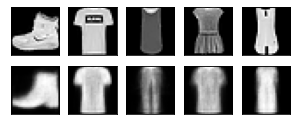

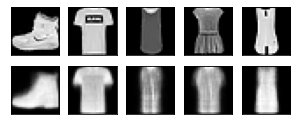

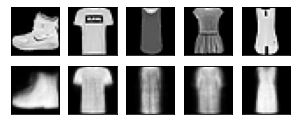

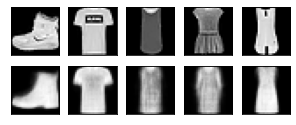

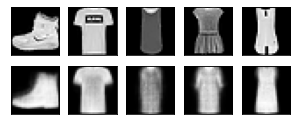

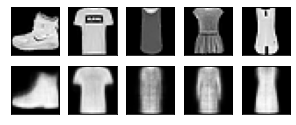

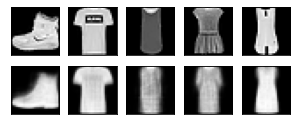

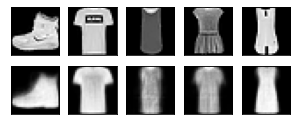

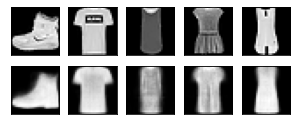

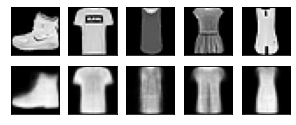

In [10]:
# 학습을 진행
for epoch in range(1, EPOCH+1): # epoch = 10이므로 총 10번 반복한다.
  train(autoencoder, train_loader)
  
  # 디코더에서 나온 이미지를 시각화하기
  test_x = view_data.to(DEVICE) 
  _, decoded_data = autoencoder(test_x)

  # 이미지를 담기 위한 틀 형성
  f, a = plt.subplots(2, 5, figsize = (5, 2))
  print("[Epoch {}]".format(epoch))

  # 앞서 생성한 틀에 차례대로 이미지를 삽입
  for i in range(5): # for(i=0; i<5; i++)
    img = np.reshape(view_data.data.numpy()[i],(28, 28))
    a[0][i].imshow(img, cmap='gray')
    a[0][i].set_xticks(());    a[0][i].set_yticks(())

  for i in range(5):
    img = np.reshape(decoded_data.to("cpu").data.numpy()[i], (28, 28))
    a[1][i].imshow(img, cmap='gray')
    a[1][i].set_xticks(());    a[1][i].set_yticks(())

plt.show() # 얘는 왜 있는거임? 없어도 이미지 출력되는데

### __잠재변수 들여다보기__
- __잠재변수__란?<br>
| 사전적 의미 : 구성개념(Constructr)이 직접적으로 관찰되거나 측정되지 않는 변수 |<br>
  다차원의 데이터가 Linear 혹은 hidden layer를 거치기 위해선 1차원 벡터로 flatten하는 작업이 필요하다. 이후, 이미지를 벡터화한 데이터에 non-linear/linear 변환 과정을 거쳐 n차원의 데이터로 만든 경우, 이미지는 각각 n개의 값으로 표현할 수 있다. 그리고 이렇게 __n개의 값__으로 표현된 것이 잠재 변수이다.<br>
  즉, 오토인코더에서의 잠재변수는 __인코더를 거쳐 최종적으로 생성된 압축된 데이터__를 의미한다. 디코더는 이러한 잠재변수를 받아 원본 데이터로 복원한다.

In [11]:
# 위 코드에서 인코더를 거친 데이터는 3개의 값으로 표현된다.
# 잠재변수를 3D 플롯으로 시각화
view_data = trainset.data[:200].view(-1, 28*28) # 학습 데이터셋으로부터 원본 이미지 200개를 준비
view_data = view_data.type(torch.FloatTensor)/255.
test_x = view_data.to(DEVICE) # 데이터를 미리 설정해둔 디바이스로 전송
encoded_data, _ = autoencoder(test_x)
encoded_data = encoded_data.to("cpu") # 오토인코더의 인코딩 된 값을 cpu로 가져오기 = 디코딩은 무시

In [12]:
# 레이블 가독성을 높히기 위한 딕셔너리
CLASSES = {
    0 : 'T-shirt/top' ,
    1 : 'Trouser' ,
    2 : 'Pullover' ,
    3 : 'Dress' ,
    4 : 'Coat' ,
    5 : 'Sandal' ,
    6 : 'Shirt' ,
    7 : 'Sneaker' ,
    8 : 'Bag' ,
    9 : 'Ankle boot' ,
}

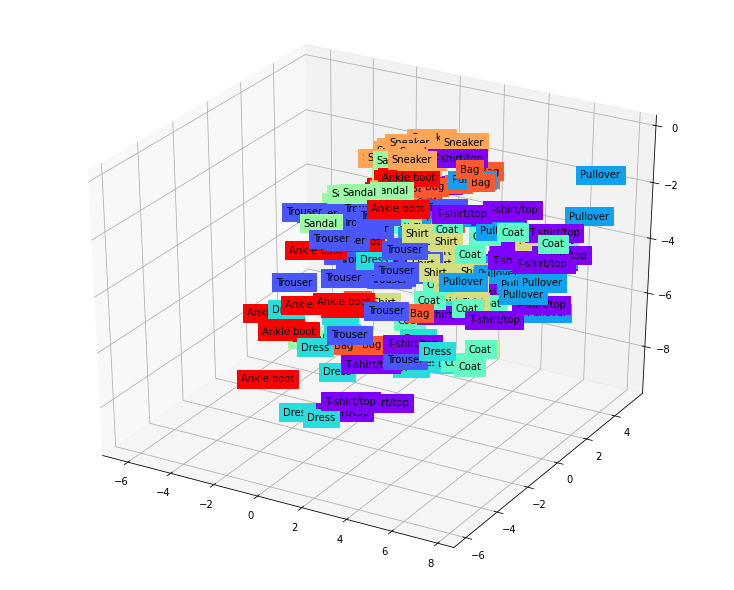

In [19]:
# 잠재변수를 3D 플롯으로 시각화하기 위한 틀 생성
fig = plt.figure(figsize=(10,8))
ax = Axes3D(fig)

# 잠재변수를 넘파이 행렬로 변환
X = encoded_data.data[:, 0].numpy()
Y = encoded_data.data[:, 1].numpy()
Z = encoded_data.data[:, 2].numpy()

labels = trainset.targets[:200].numpy()

# x, y, z와 레이블들을 zip()함수로 모아 iterable한 튜플들로 만든다.
# 이후 각 튜플에 대해 순서대로 레이블에 해당하는 색상과 좌표를 지정해준다.
for x, y, z, s in zip(X, Y, Z, labels):
  name = CLASSES[s]
  color = cm.rainbow(int(255*s/9))
  ax.text(x, y, z, name, backgroundcolor=color)

ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())

plt.show()

### __오토인코더로 망가진 이미지 복원하기__
오토인코더는 일종의'압축'을 의미하는데, 여기서의 __압축__은 __데이터의 특성에 우선순위를 매기고 낮은 순위의 데이터를 버리는 것__을 의미한다. 오토인코더의 이러한 특징을 이용하면 데이터에 존재하는 '노이즈'를 제거할 수 있다. (노이즈의 우선순위는 낮을 것이기 때문이다.)<br>
- __구현 방식__<br>
  모델 학습시, 학습 데이터에 노이즈를 삽입하여 이미지 복원 능력을 강화한다.

In [20]:
# 노이즈를 삽입하는 함수
def add_noise(img):
  noise = torch.randn(img.size()) * 0.2
  noisy_img = img + noise
  return noisy_img

In [21]:
def train(autoencoder, train_loader):
  autoencoder.train()
  avg_loss = 0
  for step, (x, label) in enumerate(train_loader) :
    noisy_x = add_noise(x) # 입력 데이터에 노이즈를 삽입
    noisy_x = noisy_x.view(-1, 28*28).to(DEVICE) # 다차원 데이터를 flatten
    y = x.view(-1, 28*28).to(DEVICE)

    label = label.to(DEVICE)
    encoded, decoded = autoencoder(noisy_x)

    loss = criterion(decoded, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer
    avg_loss += loss.item()

  return avg_loss / len(train_loader)

In [22]:
for epoch in range(1, EPOCH+1): # epoch = 10이므로 총 10번 반복한다.
  loss = train(autoencoder, train_loader)
  print("[Epoch {}] loss : {}".format(epoch, loss))

[Epoch 1] loss : 0.02385108951709545
[Epoch 2] loss : 0.02386101620244001
[Epoch 3] loss : 0.023878360163174205
[Epoch 4] loss : 0.023876235095549748
[Epoch 5] loss : 0.023860588542688122
[Epoch 6] loss : 0.023855919205049463
[Epoch 7] loss : 0.023854967433093455
[Epoch 8] loss : 0.02385820028211262
[Epoch 9] loss : 0.023859074384943127
[Epoch 10] loss : 0.02384813762962945


In [23]:
# 테스트 데이터 불러오기
testset = datasets.FashionMNIST(
    root = './.data/',
    train = False,
    download = False,
    transform = transforms.ToTensor()
)

# 테스트 데이터셋에서 이미지 한 장을 가져온다
sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

In [26]:
# 가져온 이미지를 오염시키고 모델에 통과시킨다
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

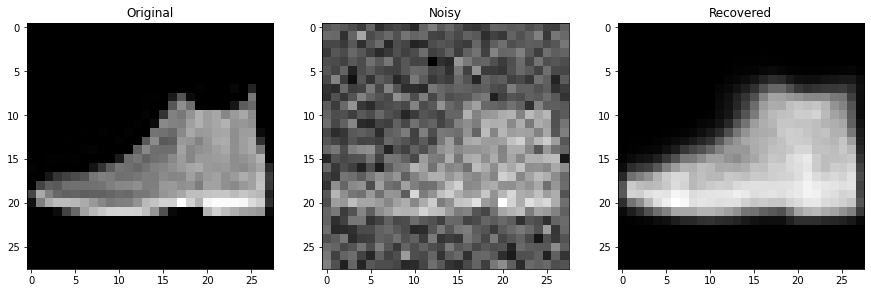

In [30]:
# 시각화를 위한 틀 생성
f, a = plt.subplots(1, 3, figsize = (15, 15))

# 시각화를 위해 데이터를 넘파이 행렬로 변환한다
original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recovered_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

# 원본/오염/복원 사진 로드
a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recovered_img, cmap='gray')

plt.show()

### __결과 분석__
복원된 이미지는 원본 이미지와 비슷하긴 하지만 경계선이 매우 흐려졌다. 앞서 언급했던 것처럼, 오토인코더는 데이터의 특징에 우선순위를 부여하고 상대적으로 덜 중요한 특징은 제거하기 때문에 이러한 차이가 발생하는 것이다.